## Importing Datasets

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_jsonl(path):
    with open(path, "r") as f:
        return [json.loads(line) for line in f]

In [3]:
TRAIN_PATH = "../data/split/train.json"
VAL_PATH = "../data/split/val.json"
TEST_PATH = "../data/split/test.json"

In [4]:
train_data = load_jsonl(TRAIN_PATH)
val_data = load_jsonl(VAL_PATH)
test_data = load_jsonl(TEST_PATH)

In [5]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

In [6]:
data_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

## Basic Visualizations

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   paper_id            14993 non-null  object
 1   paper_title         14993 non-null  object
 2   paper_abstract      14993 non-null  object
 3   paper_acceptance    14993 non-null  object
 4   meta_review         14993 non-null  object
 5   label               14993 non-null  object
 6   review_ids          14993 non-null  object
 7   review_writers      14993 non-null  object
 8   review_contents     14993 non-null  object
 9   review_ratings      14993 non-null  object
 10  review_confidences  14993 non-null  object
 11  review_reply_tos    14993 non-null  object
dtypes: object(12)
memory usage: 1.4+ MB


In [8]:
data_df["review_length"] = data_df["review_contents"].apply(lambda x: sum(len(r) for r in x) if isinstance(x, list) else 0)

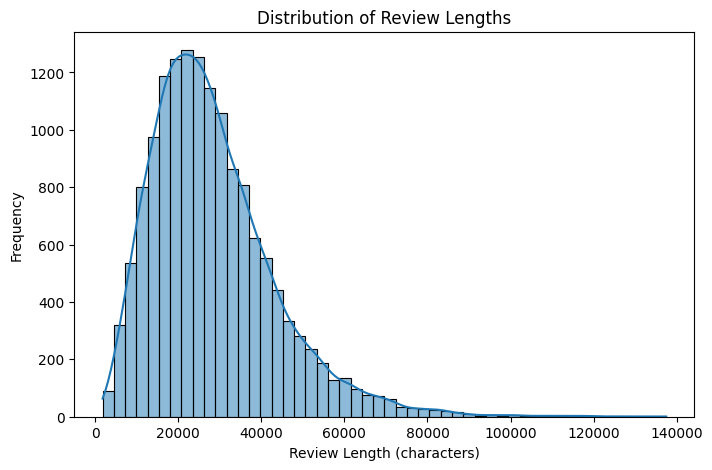

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(data_df["review_length"], bins=50, kde=True)
plt.xlabel("Review Length (characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

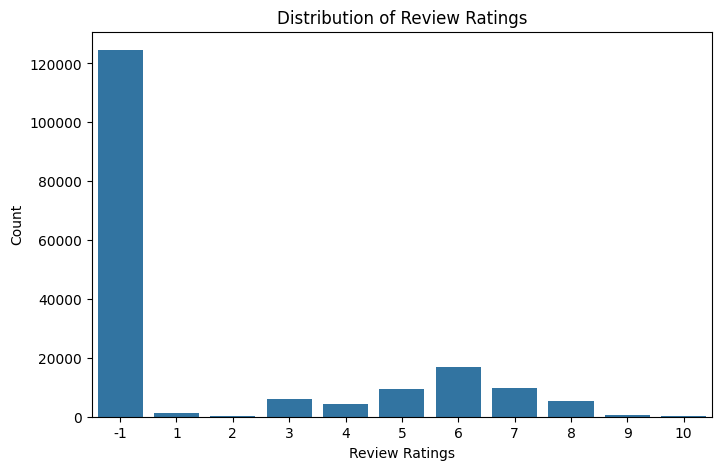

In [10]:
plt.figure(figsize=(8,5))
sns.countplot(x=sum(data_df["review_ratings"].tolist(), []))
plt.xlabel("Review Ratings")
plt.ylabel("Count")
plt.title("Distribution of Review Ratings")
plt.show()

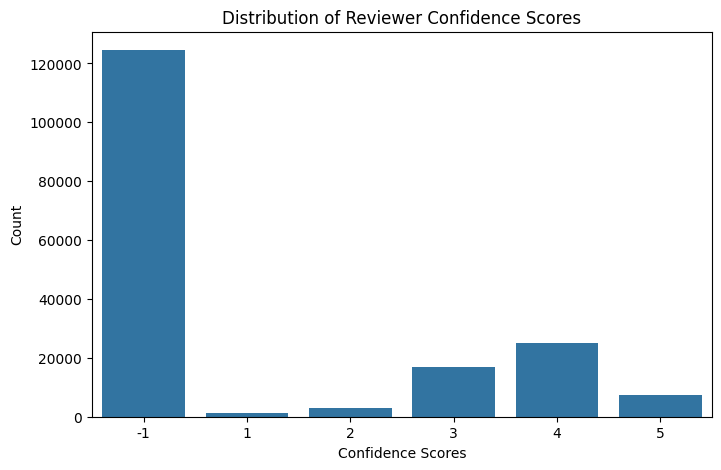

In [11]:
plt.figure(figsize=(8,5))
sns.countplot(x=sum(data_df["review_confidences"].tolist(), []))
plt.xlabel("Confidence Scores")
plt.ylabel("Count")
plt.title("Distribution of Reviewer Confidence Scores")
plt.show()

In [12]:
data_df["avg_review_rating"] = [sum(r)/len(r) if len(r)>0 else 0 for r in data_df["review_ratings"]]
agg_df = data_df.groupby("paper_acceptance")["avg_review_rating"].mean().reset_index()

In [13]:
top_5_acceptance = data_df["paper_acceptance"].value_counts().nlargest(5).index
filtered_df = data_df[data_df["paper_acceptance"].isin(top_5_acceptance)]

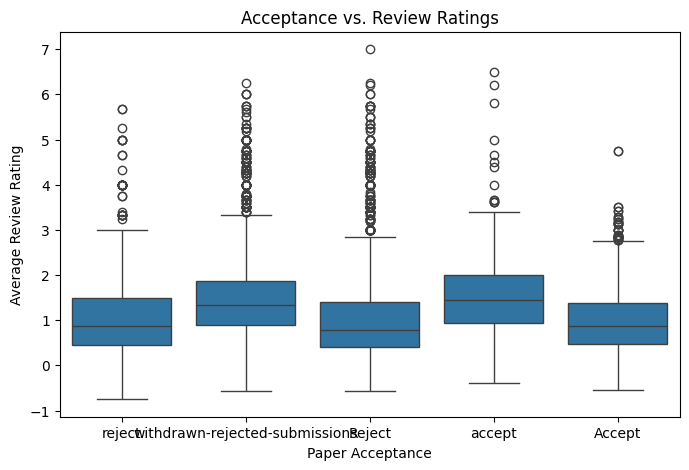

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(x=filtered_df["paper_acceptance"], y=filtered_df["avg_review_rating"])
plt.xlabel("Paper Acceptance")
plt.ylabel("Average Review Rating")
plt.title("Acceptance vs. Review Ratings")
plt.show()

In [15]:
data_df["rating_variance"] = data_df["review_ratings"].apply(lambda x: pd.Series(x).var() if len(x) > 1 else 0)

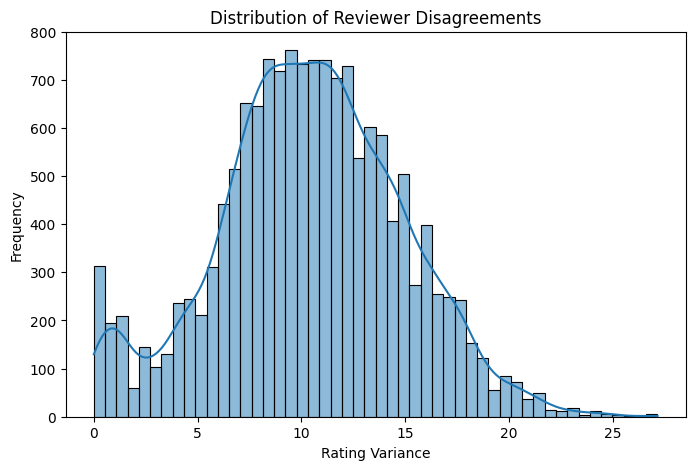

In [16]:
plt.figure(figsize=(8,5))
sns.histplot(data_df["rating_variance"], bins=50, kde=True)
plt.xlabel("Rating Variance")
plt.ylabel("Frequency")
plt.title("Distribution of Reviewer Disagreements")
plt.show()

## Advanced Visualizations

In [19]:
import numpy as np
from wordcloud import WordCloud
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [20]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to C:\Users\TIRATH
[nltk_data]     BHATHAWALA\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


C:\Users\TIRATH BHATHAWALA\AppData\Local\Temp\ipykernel_30508\4064867833.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data_df["review_confidences"].explode(), y=data_df["review_length"].explode(), palette="coolwarm")


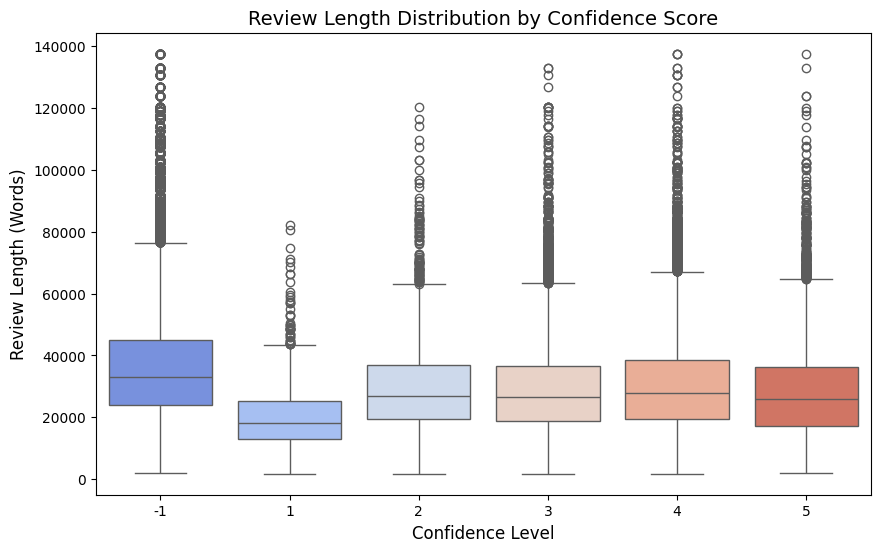

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_df["review_confidences"].explode(), y=data_df["review_length"].explode(), palette="coolwarm")
plt.xlabel("Confidence Level", fontsize=12)
plt.ylabel("Review Length (Words)", fontsize=12)
plt.title("Review Length Distribution by Confidence Score", fontsize=14)
plt.show()

In [22]:
heatmap_data = pd.DataFrame({
    "Ratings": data_df["review_ratings"].explode(),
    "Confidence": data_df["review_confidences"].explode()
})

In [23]:
heatmap_matrix = pd.crosstab(heatmap_data["Ratings"], heatmap_data["Confidence"], normalize="index")

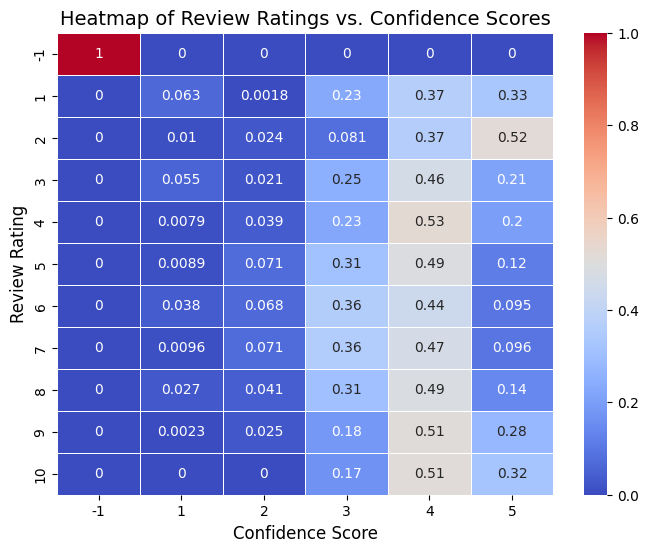

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.xlabel("Confidence Score", fontsize=12)
plt.ylabel("Review Rating", fontsize=12)
plt.title("Heatmap of Review Ratings vs. Confidence Scores", fontsize=14)
plt.show()

In [25]:
sample_size = 1000  
df_sampled = data_df.sample(n=min(sample_size, len(data_df)), random_state=42)

In [26]:
all_reviews = " ".join(review for review_list in df_sampled["review_contents"] for review in review_list)
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="coolwarm").generate(all_reviews)

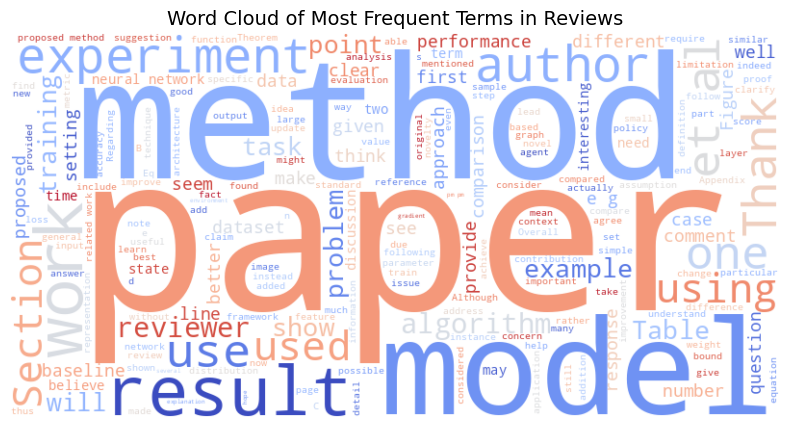

In [27]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Terms in Reviews", fontsize=14)
plt.show()

In [28]:
vectorizer = CountVectorizer(max_features=5000, stop_words="english")
review_matrix = vectorizer.fit_transform(df_sampled["review_contents"].explode())

In [29]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda_model.fit_transform(review_matrix)

In [30]:
words = vectorizer.get_feature_names_out()
top_words = 10

In [31]:
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"\nTopic {topic_idx + 1}: ", [words[i] for i in topic.argsort()[:-top_words - 1:-1]])


Topic 1:  ['model', 'paper', 'method', 'models', 'proposed', 'network', 'results', 'work', 'performance', 'different']

Topic 2:  ['training', 'table', 'accuracy', 'pm', 'results', '10', 'adversarial', 'model', 'performance', 'method']

Topic 3:  ['paper', 'authors', 'work', 'algorithm', 'learning', 'problem', 'results', 'function', 'method', 'theoretical']

Topic 4:  ['paper', 'learning', 'data', 'method', 'authors', 'work', 'training', 'results', 'model', 'task']

Topic 5:  ['gradient', 'loss', 'reviewer', 'mathcal', 'paper', 'algorithm', 'thank', 'training', 'theorem', 'does']


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=500)
review_embeddings = tfidf_vectorizer.fit_transform(df_sampled["review_contents"].explode()).toarray()

In [34]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(review_embeddings)

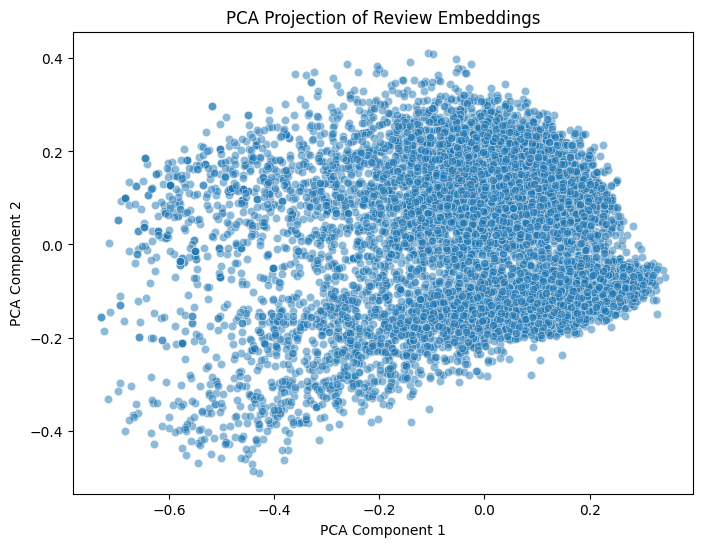

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], alpha=0.5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Review Embeddings")
plt.show()

In [36]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(review_embeddings)

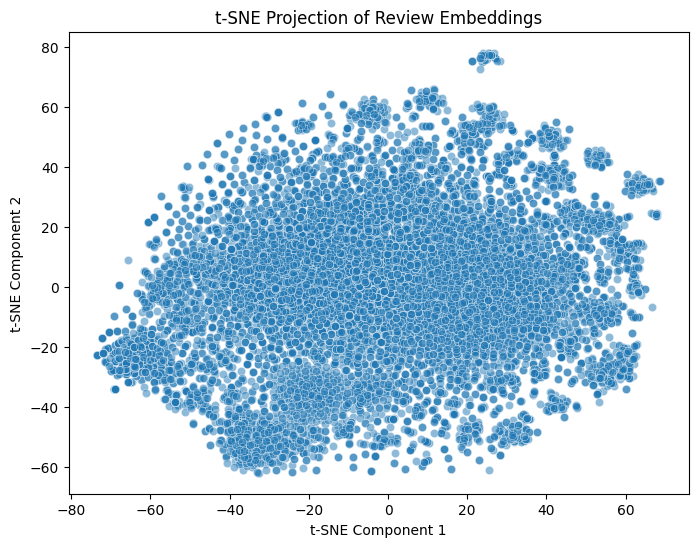

In [37]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], alpha=0.5)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Projection of Review Embeddings")
plt.show()

## Analysis

### Analysis of Reviewer Disagreements and Topic Modeling

#### 1. Reviewer Disagreements (Histogram)

The histogram shows the distribution of rating variances among reviewers, providing insights into disagreement levels. The distribution appears to be right-skewed, with a peak around a variance of 10. This suggests that while most reviews have moderate disagreement, some exhibit extreme differences. Notably, the presence of a small peak at zero indicates cases of complete reviewer consensus.

#### 2. Review Length vs. Confidence (Box Plot)

The box plot illustrates the distribution of review lengths across different confidence scores. A notable trend is that lower confidence levels (-1, 1) exhibit higher variance in review lengths. This could indicate that less confident reviewers tend to provide overly detailed or excessively brief reviews, possibly due to uncertainty. Higher confidence levels (3-5) show more consistency in review lengths, suggesting a more structured reviewing approach.

#### 3. Ratings vs. Confidence Score Correlation (Heatmap)

The heatmap highlights the relationship between review ratings and confidence scores. The distribution is concentrated around middle confidence levels, with higher ratings generally correlating with higher confidence. However, lower confidence ratings (-1, 1) appear sporadic across various review scores, implying that some reviewers lack certainty even for highly positive or negative ratings. This could suggest inconsistencies in rating calibration across reviewers. 

### Topic Modeling Insights

#### Topic 1 (Model Performance & Methods): 
This topic focuses on model performance and proposed methods, suggesting that reviewers frequently evaluate models based on their novelty and comparative results.

#### Topic 2 (Training & Accuracy Reporting): 
Mentions of "training," "accuracy," and "adversarial" indicate a focus on experimental setup and performance robustness.
#### Topic 3 (Algorithmic Foundations & Theoretical Contributions): 
This topic centers around theoretical justifications, showing that some reviews emphasize mathematical rigor and algorithmic soundness.
#### Topic 4 (General Paper Evaluation & Contributions): 
Generic terms such as "paper," "authors," and "work" suggest general feedback on the structure and contributions of submissions.
#### Topic 5 (Gradient Descent & Mathematical Formalism): 
This topic contains terms like "gradient," "loss," and "theorem," implying that reviewers often assess papers based on their mathematical formulations and theoretical underpinnings.

### Conclusion

The high disagreement in ratings suggests variability in reviewer interpretation of paper quality, which could impact fairness in acceptance decisions.

Confidence scores are not always proportional to review length, which may indicate a lack of alignment in reviewer self-assessment.

Topic modeling highlights common discussion points, with a strong focus on model performance, training methodologies, and theoretical contributions.